In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.tree import plot_tree



# Linear regression

In [2]:
def create_numeric_pipeline(choice):
    """
    Create a numeric pipeline based on the transformation choice.
    
    The pipeline always starts with a placeholder for polynomial features,
    then:
      - If choice=='log': applies np.log1p then a scaler (to be tuned via grid search)
      - If choice=='yeo-johnson': applies a scaler, a clipping function, then a PowerTransformer
      - Otherwise, just a scaler.
      
    The 'poly' and 'scaler' steps are set to 'passthrough' by default
    and can be overridden in the grid search.
    """
    steps = []
    # Step 1: polynomial features (default 'passthrough'; grid search can try a PolynomialFeatures transformer)
    steps.append(('poly', 'passthrough'))
    
    if choice == 'log':
        # Apply log transformation to numeric features
        steps.append(('log', FunctionTransformer(np.log1p, validate=True)))
        steps.append(('scaler', 'passthrough'))
    elif choice == 'yeo-johnson':
        steps.append(('scaler', 'passthrough'))
        # A clipper can help reduce the effect of extreme values before power transforming
        steps.append(('clipper', FunctionTransformer(lambda X: np.clip(X, -1e2, 1e2), validate=False)))
        steps.append(('power', PowerTransformer(method='yeo-johnson', standardize=False)))
    else:
        # No transformation; just a scaler (or none if scaler is set to passthrough)
        steps.append(('scaler', 'passthrough'))
    return Pipeline(steps)

numeric_pipeline_options = {
    'log': create_numeric_pipeline('log'),
    'yeo-johnson': create_numeric_pipeline('yeo-johnson'),
    'none': create_numeric_pipeline(None)
}




def train_model_with_grid_search(
    data: pd.DataFrame, 
    target: str,
    param_grid,
    test_size: float = 0.2, 
    random_state: int = 42,
    cv: int = 5
):
    """
    Train a regression model by scanning over preprocessing options and regressor types.
    
    This grid search will explore:
      - Three numeric processing pipelines (using a log transform, a yeo-johnson transform, or none)
      - For each numeric pipeline, whether to add polynomial features (degree=2) or not,
        and whether to apply a RobustScaler, StandardScaler, or no scaling.
      - Different regressors: Ridge, Lasso, or plain LinearRegression.
    
    The function returns a dictionary with the best model, performance metrics,
    best parameters, feature importances, and the train/test splits.
    """
    # Separate features and target
    X = data.drop(target, axis=1)
    y = data[target].copy()
    y = np.log1p(y)
    
    # Define columns for different types of features
    ordinal_columns = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
    ]
    nominal_columns = [col for col in X.select_dtypes(include=['object', 'category']).columns 
                       if col not in ordinal_columns]
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Define ordinal mappings and create an encoder for each ordinal column
    ordinal_mappings = {
        'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'OverallQual': {i: i for i in range(1, 11)},
        'OverallCond': {i: i for i in range(1, 11)},
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    }
    ordinal_transformers = []
    for col in ordinal_columns:
        ordinal_transformers.append(
            (f'ord_{col}', 
                OrdinalEncoder(
                    categories=[list(ordinal_mappings[col].keys())],
                    handle_unknown='use_encoded_value',
                    unknown_value=-1
                ), 
                [col])
        )
    
    # Build three options for numeric feature processing:

    
    # Build a ColumnTransformer that applies different transformations to different feature types.
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_columns),
            # For numerical features, we start with one of our numeric pipelines.
            ('num', numeric_pipeline_options['none'], numerical_columns)
        ] + ordinal_transformers
    )
    
    #  placeholder 
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    
    
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=cv, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Extract feature importances if available (e.g. using regressor coefficients)
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        coef = best_model.named_steps['regressor'].coef_
        try:
            # For scikit-learn >=1.0
            feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        except:
            # If that fails, build a list manually.
            feature_names = []
            if nominal_columns:
                feature_names.extend(
                    best_model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(nominal_columns)
                )
            feature_names.extend(numerical_columns)
            feature_names.extend(ordinal_columns)
        if len(feature_names) != len(coef):
            feature_names = [f'feature_{i}' for i in range(len(coef))]
        coefficients = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(coef),
            'value': coef
        }).sort_values('importance', ascending=False)
    else:
        coefficients = pd.DataFrame({
            'feature': ['N/A'],
            'importance': [0],
            'value': [0]
        })
    
    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': coefficients,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

In [3]:
param_grid = [
        {
            'preprocessor__num': [numeric_pipeline_options['log']],
            'preprocessor__num__scaler': [RobustScaler(), StandardScaler(), 'passthrough'],
            'preprocessor__num__poly': [
                'passthrough', 
                PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
            ],
            'regressor': [Ridge(), Lasso(max_iter=1000, tol=0.01, selection='random')],
            'regressor__alpha': [ 1, 10, 100, 1000, 10000]
        },
        {
            'preprocessor__num': [numeric_pipeline_options['log']],
            'preprocessor__num__scaler': [RobustScaler(), StandardScaler(), 'passthrough'],
            'preprocessor__num__poly': [
                'passthrough', 
                PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
            ],
            'regressor': [LinearRegression()]
        }
    ]

df = pd.read_csv('data/train_rm_OL.csv')  # replace with your file path
results = train_model_with_grid_search(df, target='SalePrice', param_grid=param_grid, cv = 5)

print("Best Model Performance:")
for metric, value in results['performance'].items():
    print(f"{metric}: {value}")
print("\nBest Parameters:")
for key, value in results['best_params'].items():
    print(f"{key}: {value}\n")
print("\nTop Feature Importances:")
print(results['feature_importances'].head(10))

Best Model Performance:
root_mean_squared_error: 19640.725695885572
r2_score: 0.936128587857078

Best Parameters:
preprocessor__num: Pipeline(steps=[('poly', 'passthrough'),
                ('log',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('scaler', 'passthrough')])

preprocessor__num__poly: passthrough

preprocessor__num__scaler: StandardScaler()

regressor: Ridge()

regressor__alpha: 10


Top Feature Importances:
                   feature  importance     value
0         MSZoning_C (all)    0.109538 -0.109538
301              GrLivArea    0.094752  0.094752
33    Neighborhood_Crawfor    0.087028  0.087028
297            TotalBsmtSF    0.064556  0.064556
149         Functional_Typ    0.057231  0.057231
321            OverallQual    0.056692  0.056692
280  SaleCondition_Abnorml    0.056480 -0.056480
92     Exterior1st_BrkFace    0.056210  0.056210
49    Neighborhood_StoneBr    0.054847  0.054847
251     GarageYrBlt_2008.0    0.050071  

Some features engineering seem to improve the model slightly, but I will not proceed with developing this. Nonetheless it is quite amazing that by feature engineering we can probably get the R2 up to 0.94 if interaction terms are included.

In [4]:
df = pd.read_csv('data/train_rm_OL.csv')  

# df = pd.read_csv('data/train_cleaned.csv')
df['BsmtFinSF1_squared'] = df['BsmtFinSF1'] ** 2
df['TotalBsmtSF_squared'] = df['TotalBsmtSF'] ** 2
df['GrLivArea_squared'] = df['GrLivArea'] ** 2

results = train_model_with_grid_search(df, target='SalePrice', param_grid=param_grid)

print("Best Model Performance:")
for metric, value in results['performance'].items():
    print(f"{metric}: {value}")

Best Model Performance:
root_mean_squared_error: 19527.255775975875
r2_score: 0.9368644617519224


Visualization of residuals for feature engineering

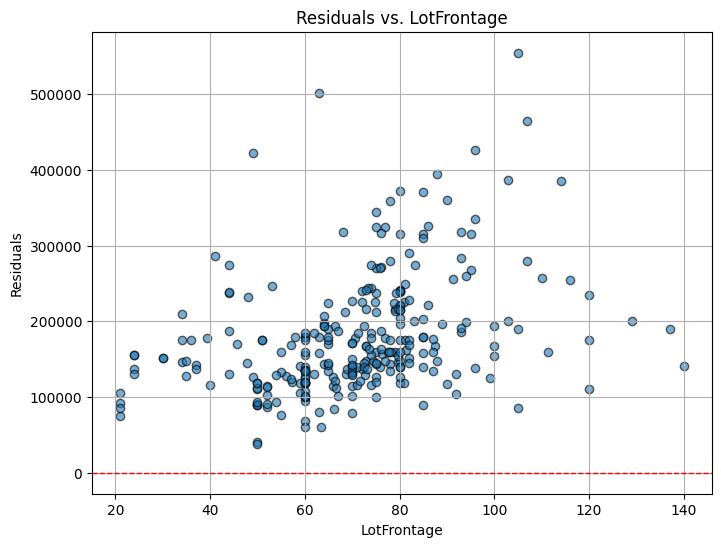

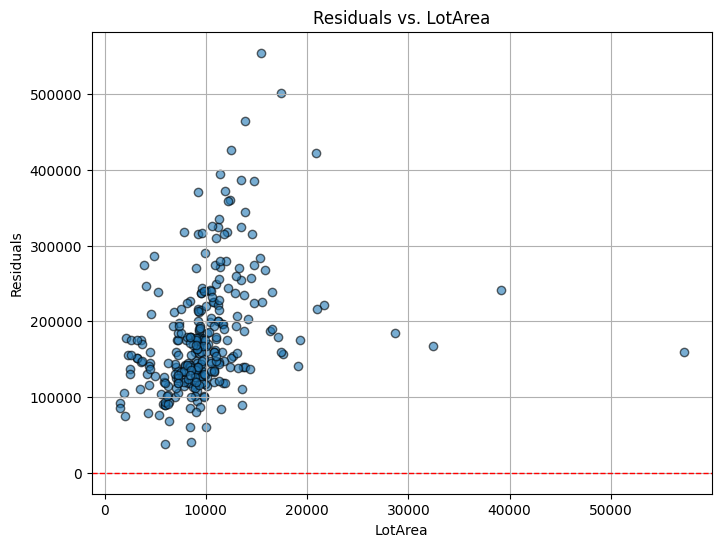

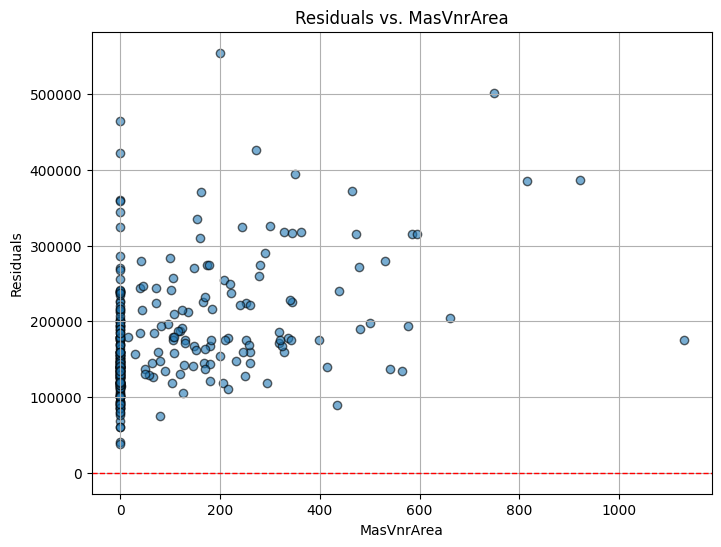

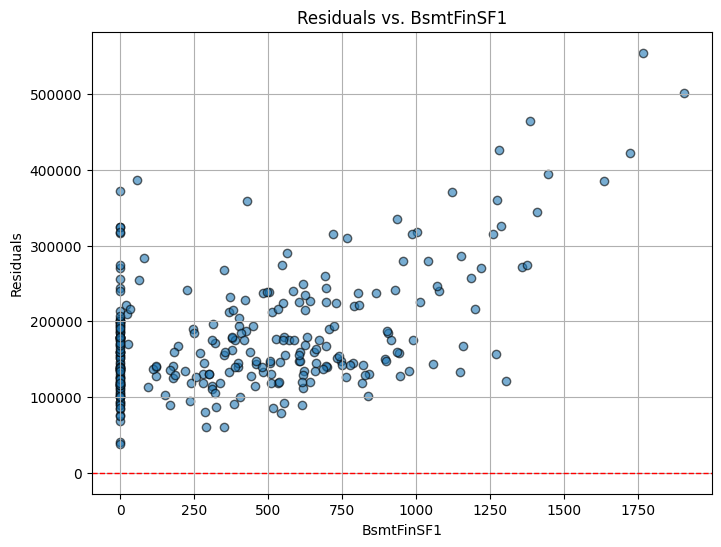

In [5]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_residuals_by_feature(model_output: dict, features: list = None):
    """
    Plot residuals (test set errors) versus specified features from the original test set.
    
    Parameters:
    -----------
    model_output : dict
        The dictionary returned by train_linear_regression.
        
    Notes:
    ------
    - This function uses the original X_test (i.e., before any transformation in the pipeline)
      so that the plots reflect the raw feature values.
    """
    # Unpack the test data and model from the output dictionary
    X_test, y_test = model_output['test_data']
    model = model_output['model']
    
    # Compute predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # If features are not specified, plot for every feature in X_test.
    if features is None:
        features = X_test.columns.tolist()
    
    # Plot residuals versus each specified feature
    for feature in features:
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[feature], residuals, alpha=0.6, edgecolor='k')
        plt.xlabel(feature)
        plt.ylabel("Residuals")
        plt.title(f"Residuals vs. {feature}")
        plt.axhline(0, color='red', linestyle='--', linewidth=1)
        plt.grid(True)
        plt.show()

    
    
# plot_residuals_by_feature(results, ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd'])
# plot_residuals_by_feature(results, ['OverallQual', 'OverallCond', 'ExterQual'])
plot_residuals_by_feature(results, ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1'])


### Linear regression conclusions:

This result is pretty impresive for linear regression.

From above we can see, that the best R2 is obtained for data without outliers 

# Decision tree

Best Model Performance:
root_mean_squared_error: 36345.50979130225
r2_score: 0.7812777387953476

Best Parameters:
preprocessor__num: Pipeline(steps=[('identity', 'passthrough'),
                ('log',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True)),
                ('scaler', 'passthrough')])

preprocessor__num__scaler: passthrough

regressor__ccp_alpha: 0.0

regressor__max_depth: 15

regressor__max_features: None

regressor__min_samples_leaf: 10

regressor__min_samples_split: 2


Top Feature Importances:
              feature  importance
289       OverallQual    0.530047
301         GrLivArea    0.132162
297       TotalBsmtSF    0.080275
311        GarageArea    0.078876
310        GarageCars    0.030685
294        BsmtFinSF1    0.017320
258  GarageFinish_Unf    0.015811
291         YearBuilt    0.013768
290       OverallCond    0.011686
137      CentralAir_Y    0.011606


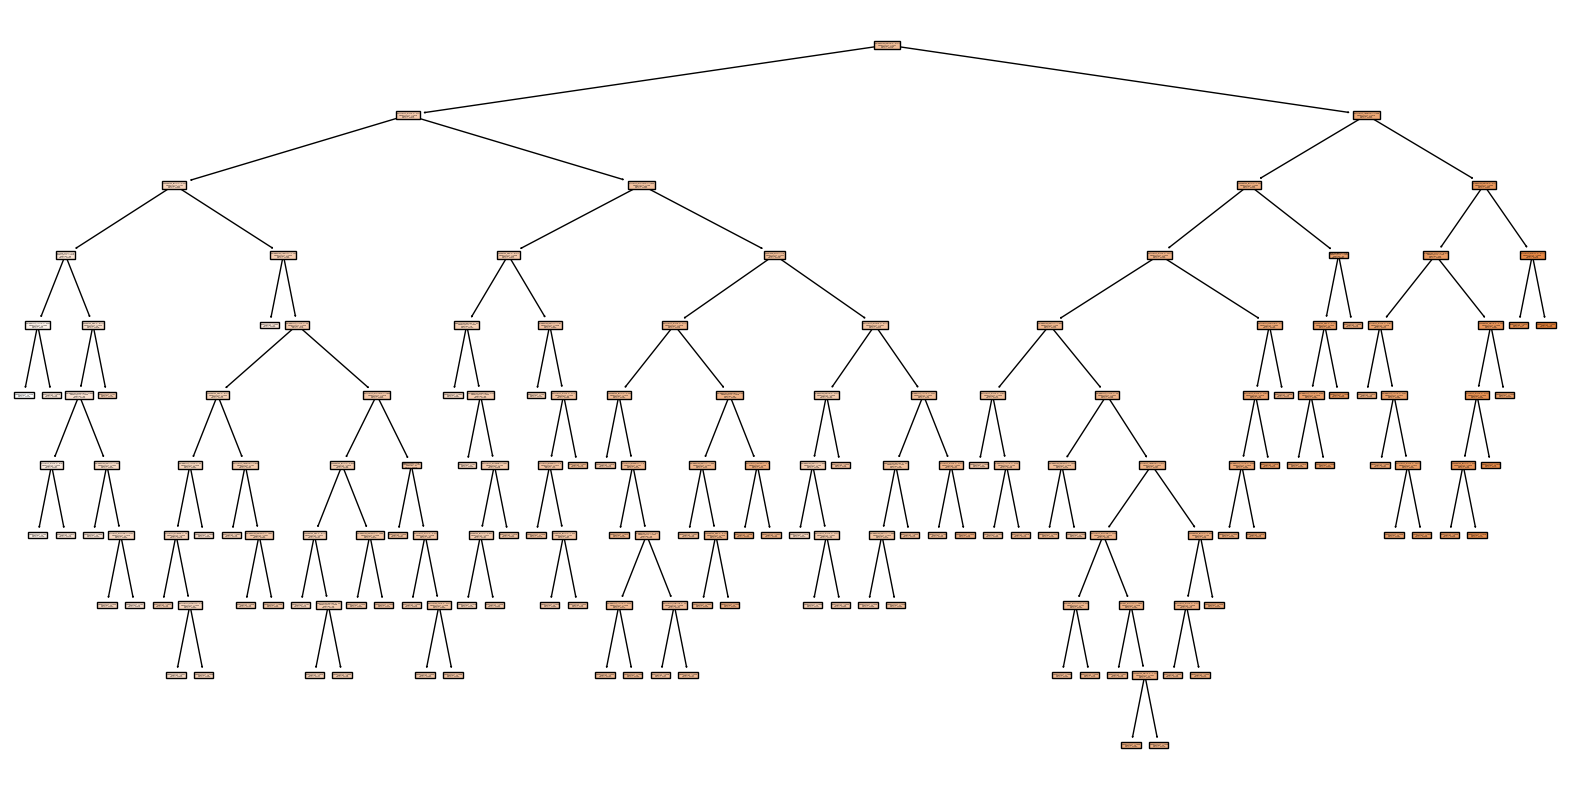

In [6]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def create_numeric_pipeline_dt(choice):
    """
    Create a numeric pipeline for decision tree regression to reduce the clutter in the following function.
  
    """
    steps = []
    steps.append(('identity', 'passthrough'))
    
    if choice == 'log':
        steps.append(('log', FunctionTransformer(np.log1p, validate=True)))
        steps.append(('scaler', 'passthrough'))
    elif choice in ['robust', 'standard']:
        steps.append(('scaler', 'passthrough'))
    elif choice in ['log+robust', 'log+standard']:
        steps.append(('log', FunctionTransformer(np.log1p, validate=True)))
        steps.append(('scaler', 'passthrough'))
    else:
        steps.append(('scaler', 'passthrough'))
    return Pipeline(steps)

numeric_pipeline_options_dt = {
    'log': create_numeric_pipeline_dt('log'),
    'robust': create_numeric_pipeline_dt('robust'),
    'standard': create_numeric_pipeline_dt('standard'),
    'log+robust': create_numeric_pipeline_dt('log+robust'),
    'log+standard': create_numeric_pipeline_dt('log+standard'),
    'none': create_numeric_pipeline_dt(None)
}


def train_decision_tree_with_grid_search(
    data: pd.DataFrame,
    target: str,
    param_grid,
    test_size: float = 0.2,
    random_state: int = 42,
    cv: int = 5
):
    """
    Train a decision tree regression model by scanning over preprocessing options
    and regressor hyperparameters.
   
    Returns a dictionary with the best model, performance metrics, best parameters,
    feature importances, and the train/test splits.
    """
    X = data.drop(target, axis=1)
    y = np.log1p(data[target])
    
    ordinal_columns = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
    ]
    # Only keep ordinal columns that exist in the dataset
    ordinal_columns = [col for col in ordinal_columns if col in X.columns]
    
    nominal_columns = [col for col in X.select_dtypes(include=['object', 'category']).columns
                       if col not in ordinal_columns]
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    ordinal_mappings = {
        'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'OverallQual': {i: i for i in range(1, 11)},
        'OverallCond': {i: i for i in range(1, 11)},
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
        'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    }
    ordinal_transformers = []
    for col in ordinal_columns:
        ordinal_transformers.append(
            (f'ord_{col}',
             OrdinalEncoder(
                 categories=[list(ordinal_mappings[col].keys())],
                 handle_unknown='use_encoded_value',
                 unknown_value=-1
             ),
             [col])
        )
    
    # Build the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_columns), #OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            # Start with a default numeric pipeline ('none'); grid search will try others
            ('num', numeric_pipeline_options_dt['none'], numerical_columns)
        ] + ordinal_transformers
    )
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=random_state))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Extract feature importances from the decision tree
    importances = best_model.named_steps['regressor'].feature_importances_
    try:
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    except:
        # Fallback if get_feature_names_out is not available
        feature_names = []
        if nominal_columns:
            feature_names.extend(
                best_model.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(nominal_columns)
            )
        feature_names.extend(numerical_columns)
        feature_names.extend(ordinal_columns)
        if len(feature_names) != len(importances):
            feature_names = [f'feature_{i}' for i in range(len(importances))]
    
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': feature_importances,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

param_grid = [
    {
        'preprocessor__num': [
            numeric_pipeline_options_dt['log'],
            numeric_pipeline_options_dt['robust'],
            numeric_pipeline_options_dt['standard'],
            numeric_pipeline_options_dt['log+robust'],
            numeric_pipeline_options_dt['log+standard'],
            numeric_pipeline_options_dt['none']
        ],
        # For the inner scaler step, let grid search choose between a scaler or 'passthrough'
        'preprocessor__num__scaler': ['passthrough'],
        'regressor__max_depth': [10, 15, 20],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [4, 6, 8, 10],
        'regressor__max_features': [None],
        'regressor__ccp_alpha': [0.0, 0.00001]
    }
]

df = pd.read_csv('data/train_rm_OL.csv')

results_tree = train_decision_tree_with_grid_search(
    df, target='SalePrice', param_grid=param_grid, cv=5
)

print("Best Model Performance:")
for metric, value in results_tree['performance'].items():
    print(f"{metric}: {value}")
print("\nBest Parameters:")
for key, value in results_tree['best_params'].items():
    print(f"{key}: {value}\n")
print("\nTop Feature Importances:")
print(results_tree['feature_importances'].head(10))

best_model_dt = results_tree['model'].named_steps['regressor']
feature_names = list(results_tree['feature_importances']['feature'])

plt.figure(figsize=(20, 10))
plot_tree(best_model_dt, filled=True, feature_names=feature_names)
plt.show()


Trees are way worse than linear regression, which may indicate that non-linearities are not extreme in the dataset.